# Evaluate route origin validation status versus riswhois validity

This workbook evaluates the ROV status for all riswhois entries.
Then, for each RIPE Atlas probe, it matches the riswhois entries that match
the (v4/v6) address of each probe, and evaluates the rov status for the set
of announcements for each probe.

Finally it prints what probes are IPv4/IPv6 ROV invalid.

Along the way the workbook also prints multiple charts on riswhois visibility
and on ROV status.

In [1]:
# Add parent dir to path
import os,sys

sys.path.insert(0,os.environ['PWD'])

In [2]:
import bz2
import json
import ipaddress

import altair as alt
import pandas as pd
import requests

from rpki_analysis.riswhois import RisWhoisLookup, read_ris_dump
from rpki_analysis.rov import RouteOriginAuthorizationLookup, rov_validity, rov_validity_verbose

In [3]:
# https://www.ris.ripe.net/dumps/riswhoisdump.IPv4.gz
# https://www.ris.ripe.net/dumps/riswhoisdump.IPv6.gz
ris_v4_gz = requests.get("https://www.ris.ripe.net/dumps/riswhoisdump.IPv4.gz").content
ris_v6_gz = requests.get("https://www.ris.ripe.net/dumps/riswhoisdump.IPv6.gz").content


In [4]:
# Atlas Probe archive
atlas_probes_bz2 = requests.get("https://ftp.ripe.net/ripe/atlas/probes/archive/meta-latest").content
atlas_probes = pd.DataFrame(json.loads(bz2.decompress(atlas_probes_bz2))['objects'])

In [5]:
ris_v4 = read_ris_dump("https://www.ris.ripe.net/dumps/riswhoisdump.IPv4.gz")
ris_v6 = read_ris_dump("https://www.ris.ripe.net/dumps/riswhoisdump.IPv6.gz")

RIS dump contains row(s) with AS_SET! These will never be RPKI valid (https://tools.ietf.org/html/rfc6907#section-7.1.8)
RIS dump contains row(s) with AS_SET! These will never be RPKI valid (https://tools.ietf.org/html/rfc6907#section-7.1.8)


In [6]:
# Get RPKI valids
validated_objects = requests.get("https://rpki-validator.ripe.net/api/objects/validated").json()
rpki_roas = pd.DataFrame(validated_objects['data']['roas'])
# And add address family
rpki_roas['af'] = af = rpki_roas.prefix.map(lambda p: ipaddress.ip_network(p).version)
# And prefix length (to chart later)
rpki_roas['prefix_length'] = af = rpki_roas.prefix.map(lambda p: ipaddress.ip_network(p).prefixlen)

In [7]:
rpki_roas_v4 = rpki_roas[rpki_roas.af == 4]
rpki_roas_v6 = rpki_roas[rpki_roas.af == 6]

In [8]:
roa_lookup_v4 = RouteOriginAuthorizationLookup(rpki_roas_v4)
roa_lookup_v6 = RouteOriginAuthorizationLookup(rpki_roas_v6)

In [9]:
# This prefix has a ROA for a less specific
roa_lookup_v4['1.6.108.0/24']

{RouteOriginAuthorization(asn='9583', prefix='1.6.108.0/22', max_length=22, prefix_length=22),
 RouteOriginAuthorization(asn='9583', prefix='1.6.108.0/24', max_length=24, prefix_length=24)}

### Data has been loaded

Spot-check a sample from the roas in the prefix tries for both address families. Filter so it is a sample not from the most-common prefix length.

Starting with IPv4:

In [10]:
rpki_roas_v4.describe()

,maxLength,af,prefix_length
count,225656.000000,225656.0,225656.000000
mean,23.196379,4.0,22.520168
std,2.190682,0.0,2.288992
min,8.000000,4.0,8.000000
25%,23.000000,4.0,22.000000
50%,24.000000,4.0,24.000000
75%,24.000000,4.0,24.000000
max,32.000000,4.0,32.000000


In [11]:
sample = rpki_roas_v4[rpki_roas_v4.prefix_length != 24].sample(5).reset_index()
display(sample)

,index,asn,prefix,maxLength,af,prefix_length
0,87195,13335,172.69.76.0/22,22,4,22
1,69366,136712,114.142.164.0/22,24,4,22
2,241846,63949,109.74.192.0/20,24,4,20
3,70081,137182,103.155.8.0/23,23,4,23
4,111713,198949,162.129.0.0/16,24,4,16


In [12]:
roa_lookup_v4.trie[sample.prefix[0]]

{RouteOriginAuthorization(asn='13335', prefix='172.69.76.0/22', max_length=22, prefix_length=22)}

The printed entry should match the `prefix_length` in the top row of the table.

<AxesSubplot:ylabel='Frequency'>

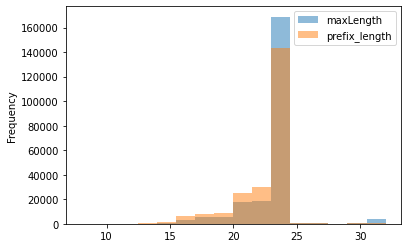

In [13]:
rpki_roas_v4[['maxLength', 'prefix_length']].plot.hist(
    by='maxLength',
    bins=16,
    alpha=0.5
)

And now IPv6, again skipping what is likely the most common prefix_length

In [14]:
rpki_roas_v6.describe()

,maxLength,af,prefix_length
count,41893.000000,41893.0,41893.000000
mean,44.492803,6.0,42.211849
std,10.487946,0.0,8.589066
min,19.000000,6.0,19.000000
25%,38.000000,6.0,32.000000
50%,48.000000,6.0,48.000000
75%,48.000000,6.0,48.000000
max,128.000000,6.0,128.000000


In [15]:
sample = rpki_roas_v6[rpki_roas_v6.prefix_length != 48].sample(5).reset_index()
display(sample)

,index,asn,prefix,maxLength,af,prefix_length
0,223131,50535,2a00:ce80::/32,48,6,32
1,20714,9873,2400:aa00:dc00::/40,40,6,40
2,132880,267914,2803:8e60::/32,32,6,32
3,22320,10021,2400:1000::/32,128,6,32
4,256839,205581,2a0b:8245::/32,32,6,32


In [16]:
roa_lookup_v6.trie[sample.prefix[0]]

{RouteOriginAuthorization(asn='50535', prefix='2a00:ce80::/32', max_length=48, prefix_length=32)}

<AxesSubplot:ylabel='Frequency'>

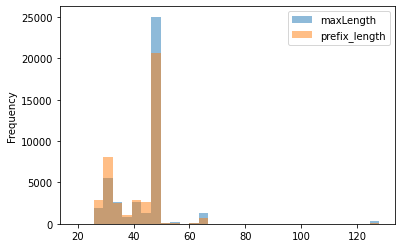

In [17]:
rpki_roas_v6[['maxLength', 'prefix_length']].plot.hist(
    by='maxLength',
    bins=32,
    alpha=0.5
)

All data has been collected.

In [18]:
ris_v4

,origin,prefix,seen_by_peers,prefix_length
16,174,0.0.0.0/0,6.0,0
17,55720,0.0.0.0/0,2.0,0
18,30823,0.0.0.0/0,1.0,0
19,50628,0.0.0.0/0,2.0,0
20,44356,0.0.0.0/0,1.0,0
...,...,...,...,...
1010482,63199,223.255.250.0/24,337.0,24
1010483,63199,223.255.251.0/24,337.0,24
1010484,58519,223.255.252.0/24,340.0,24
1010485,58519,223.255.253.0/24,340.0,24


In [19]:

ris_v4.sample(1).apply(lambda x: rov_validity(x, roa_lookup_v4), axis=1)

453581    unknown
dtype: object

In [20]:
ris_v4['roa_validity'] = ris_v4.apply(lambda x: rov_validity(x, roa_lookup_v4), axis=1)
ris_v6['roa_validity'] = ris_v6.apply(lambda x: rov_validity(x, roa_lookup_v6), axis=1)


In [21]:
# And build patricia trie
ris_v4_lookup = RisWhoisLookup(ris_v4)
ris_v6_lookup = RisWhoisLookup(ris_v6)

In [22]:
ris_v4[ris_v4.roa_validity == "unknown"].sample(20)

,origin,prefix,seen_by_peers,prefix_length,roa_validity
5694,9198,2.133.164.0/22,361.0,22,unknown
856783,270473,200.58.248.0/22,397.0,22,unknown
186044,14905,67.233.96.0/19,344.0,19,unknown
842143,203999,198.240.112.0/24,345.0,24,unknown
467728,17488,125.99.212.0/22,369.0,22,unknown
615199,26599,177.25.200.0/21,240.0,21,unknown
913817,21518,204.107.242.0/24,380.0,24,unknown
547220,21565,159.117.164.0/24,336.0,24,unknown
568197,19994,166.78.199.226/32,3.0,32,unknown
220851,9009,77.81.136.0/24,337.0,24,unknown


In [23]:
# Take the RPKI smiley range, from https://sg-pub.ripe.net/jasper/rpki-web-test/
# and lookup what it is announced by
# e.g. `whois -h riswhois.ripe.net 209.24.0.3`
# the announcement is for 209.24.0.0/24
display(ris_v4[(ris_v4.roa_validity == "invalid") & (ris_v4.prefix == '209.24.0.0/24')])
# or:
ris_v4_lookup['209.24.0.3']

,origin,prefix,seen_by_peers,prefix_length,roa_validity
941055,15562,209.24.0.0/24,202.0,24,invalid


{ExpandedRisEntry(origin='1299', prefix='0.0.0.0/0', seen_by_peers=10.0, prefix_length=0, roa_validity='unknown'),
 ExpandedRisEntry(origin='15562', prefix='209.24.0.0/24', seen_by_peers=202.0, prefix_length=24, roa_validity='invalid')}

In [24]:
def is_in_valid_v4(prefix: str):
    if not prefix:
        return None
    was_unknown = False
    
    if prefix not in ris_v4_lookup:
        return None
    
    for route in ris_v4_lookup[prefix]:
        has_route = True
        if route.roa_validity == 'valid':
            return "valid"
        if route.roa_validity == 'unknown':
            was_unknown = True
                
    return "unknown" if was_unknown else "invalid"

def is_in_valid_v6(prefix: str):
    if not prefix:
        return None
    was_unknown = False
    
    if prefix not in ris_v6_lookup:
        return None
    
    for route in ris_v6_lookup[prefix]:
        if route.roa_validity == 'valid':
            return "valid"
        if route.roa_validity == 'unknown':
            was_unknown = True
            
    return "unknown" if was_unknown else "invalid"



In [25]:
# Invalid
display(is_in_valid_v4("209.24.0.3"))
# valid
display(is_in_valid_v4("193.0.1.6"))
# Unknown
display(is_in_valid_v4("138.204.43.1"))

'unknown'

'valid'

'unknown'

In [26]:
atlas_probes['address_v4_rov'] = atlas_probes.address_v4.map(is_in_valid_v4)
atlas_probes['address_v6_rov'] = atlas_probes.address_v6.map(is_in_valid_v6)

In [27]:
atlas_probes[(atlas_probes.address_v4_rov == 'invalid')]

,id,address_v4,address_v6,asn_v4,asn_v6,prefix_v4,prefix_v6,is_anchor,is_public,status,...,total_uptime,tags,country_code,latitude,longitude,day,probe,status_name,address_v4_rov,address_v6_rov


In [28]:
active_probes_v4_or_v6_invalid = atlas_probes[((atlas_probes.address_v4_rov == 'invalid') | (atlas_probes.address_v6_rov == 'invalid')) & (atlas_probes.status_name != 'Abandoned')]

In [33]:
if not active_probes_v4_or_v6_invalid.empty:
    active_probes_v4_or_v6_invalid.sample(5)

In [34]:
atlas_probes[((atlas_probes.address_v4_rov == 'invalid')) & (atlas_probes.status_name != 'Abandoned')]

,id,address_v4,address_v6,asn_v4,asn_v6,prefix_v4,prefix_v6,is_anchor,is_public,status,...,total_uptime,tags,country_code,latitude,longitude,day,probe,status_name,address_v4_rov,address_v6_rov


In [35]:
# ris_v4[['roa_validity', 'seen_by_peers']].plot.hist(
#     by='seen_by_peers',
#     bins=16,
#     alpha=0.5
# )

seen_by_peers_count_by_roa_validity = ris_v4.groupby(['roa_validity', 'seen_by_peers'], as_index=False).agg({'prefix': 'count'})

rov_chart = alt.Chart(
    seen_by_peers_count_by_roa_validity).mark_bar()\
.encode(
    alt.X("seen_by_peers:Q", bin=False),
    alt.Color("roa_validity:N"),
    y='prefix',
).properties(
    title='Visibility versus ROV status',
    width=300,
    height=150,
).facet(
    column='roa_validity',
).resolve_scale(
    y='independent'
)

#rov_chart.save("ris_v4_rov_chart.png")
display(rov_chart)

alt.FacetChart(...)